# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
plt.style.use('ggplot')
from matplotlib.pyplot import figure
from sklearn import preprocessing

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import tensorflow as tf

# Helper Functions

In [11]:
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


In [12]:
def plot(self, model=None, plot_col='PM10 (107)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')


In [13]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds


def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels




In [29]:
MAX_EPOCHS = 20
def models(df):
  # df = df_fillna_b
  for cols in df.columns:
    if cols == 'Slut':
      del df['Slut']
    elif cols == 'Black Carbon (410)':
      del df['Black Carbon (410)']
  column_indices = {name: i for i, name in enumerate(df.columns)}

  n = len(df)

  cols = df.columns
  x = df.values #returns a numpy array
  sc = StandardScaler()
  x_scaled = sc.fit_transform(x)
  df = pd.DataFrame(x_scaled)

  
  df.columns = cols

  train_df = df[0:int(n*0.7)]
  val_df = df[int(n*0.7):int(n*0.85)]
  test_df = df[int(n*0.85):]

  num_features = df.shape[1]
  # return(train_df,val_df,test_df,num_features)
  train_mean = train_df.mean()
  train_std = train_df.std()

  # train_df = (train_df - train_mean) / train_std
  # val_df = (val_df - train_mean) / train_std
  # test_df = (test_df - train_mean) / train_std

  df_std = (df - train_mean) / train_std
  df_std = df_std.melt(var_name='Column', value_name='Normalized')
  plt.figure(figsize=(12, 6))
  ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
  _ = ax.set_xticklabels(df.keys(), rotation=90)

  class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
      # Store the raw data.
      self.train_df = train_df
      self.val_df = val_df
      self.test_df = test_df

      # Work out the label column indices.
      self.label_columns = label_columns
      if label_columns is not None:
        self.label_columns_indices = {name: i for i, name in
                                      enumerate(label_columns)}
      self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

      # Work out the window parameters.
      self.input_width = input_width
      self.label_width = label_width
      self.shift = shift

      self.total_window_size = input_width + shift

      self.input_slice = slice(0, input_width)
      self.input_indices = np.arange(self.total_window_size)[self.input_slice]

      self.label_start = self.total_window_size - self.label_width
      self.labels_slice = slice(self.label_start, None)
      self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
      return '\n'.join([
          f'Total window size: {self.total_window_size}',
          f'Input indices: {self.input_indices}',
          f'Label indices: {self.label_indices}',
          f'Label column name(s): {self.label_columns}'])


  WindowGenerator.split_window = split_window
  WindowGenerator.plot = plot
  WindowGenerator.make_dataset = make_dataset

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  WindowGenerator.train = train
  WindowGenerator.val = val
  WindowGenerator.test = test
  WindowGenerator.example = example



  single_step_window = WindowGenerator(
      input_width=1, label_width=1, shift=1,
      label_columns=['PM10 (107)'])
  # single_step_window
  
  # Baseline model
  print('Baseline model')

  class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
      super().__init__()
      self.label_index = label_index

    def call(self, inputs):
      if self.label_index is None:
        return inputs
      result = inputs[:, :, self.label_index]
      return result[:, :, tf.newaxis]

  baseline = Baseline(label_index=column_indices['PM10 (107)'])

  baseline.compile(loss=tf.losses.MeanSquaredError(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

  val_performance = {}
  performance = {}
  val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
  performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

  wide_window = WindowGenerator(input_width=24, label_width=24, shift=1,label_columns=['PM10 (107)'])

  # wide_window.plot(baseline)

  # Linear
  print('Linear model')
  linear = tf.keras.Sequential([
      tf.keras.layers.Dense(units=1)
  ])

  MAX_EPOCHS = 20

  history = compile_and_fit(linear, single_step_window)

  val_performance['Linear'] = linear.evaluate(single_step_window.val)
  performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

  # wide_window.plot(linear)

  # Dense model
  print('Dense model')
  dense = tf.keras.Sequential([
      tf.keras.layers.Dense(units=64, activation='relu'),
      tf.keras.layers.Dense(units=64, activation='relu'),
      tf.keras.layers.Dense(units=1)
  ])

  history = compile_and_fit(dense, single_step_window)

  val_performance['Dense'] = dense.evaluate(single_step_window.val)
  performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

  # wide_window.plot(dense)

  # Multi Dense model
  print('Multi dense model')

  CONV_WIDTH = 3
  conv_window = WindowGenerator(
      input_width=CONV_WIDTH,
      label_width=1,
      shift=1,
      label_columns=['PM10 (107)'])

  conv_window

  multi_step_dense = tf.keras.Sequential([
      # Shape: (time, features) => (time*features)
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=1),
      # Add back the time dimension.
      # Shape: (outputs) => (1, outputs)
      tf.keras.layers.Reshape([1, -1]),
  ])
  history = compile_and_fit(multi_step_dense, conv_window)

  IPython.display.clear_output()
  val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
  performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

  # wide_window.plot(multi_step_dense)

  # CNN
  print('CNN model')
  conv_model = tf.keras.Sequential([
      tf.keras.layers.Conv1D(filters=32,
                            kernel_size=(CONV_WIDTH,),
                            activation='relu'),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=1),
  ])

  history = compile_and_fit(conv_model, conv_window)

  IPython.display.clear_output()
  val_performance['Conv'] = conv_model.evaluate(conv_window.val)
  performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

  # LSTM
  print('LSTM model')
  lstm_model = tf.keras.models.Sequential([
      # Shape [batch, time, features] => [batch, time, lstm_units]
      tf.keras.layers.LSTM(32, return_sequences=True),
      # Shape => [batch, time, features]
      tf.keras.layers.Dense(units=1)
  ])

  history = compile_and_fit(lstm_model, wide_window)

  IPython.display.clear_output()
  val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
  performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
  
  x = np.arange(len(performance))
  width = 0.3
  # figsize=(12, 8)
  metric_name = 'mean_absolute_error'
  metric_index = lstm_model.metrics_names.index('mean_absolute_error')
  val_mae = [v[metric_index] for v in val_performance.values()]
  test_mae = [v[metric_index] for v in performance.values()]
  plt.subplots(figsize=(12, 8)) 
  plt.ylabel('mean_absolute_error [PM10 (107), normalized]')

  plt.bar(x - 0.17, val_mae, width, label='Validation')
  plt.bar(x + 0.17, test_mae, width, label='Test')
  # plt.figure(figsize=(12, 8))
  plt.xticks(ticks=x, labels=performance.keys(),
            rotation=45)
  _ = plt.legend()
  # return (lstm_model, val_performance, performance)
  print('Performance on validation data {}'.format(val_performance))
  print('Performance on test data {}'.format(performance))
# models(df_deleted)


# Raw Data

In [2]:
def missing_values(df):
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())
        print('{} - {}%'.format(col, round(pct_missing*100)))
    
    for col in df.columns:
        missing = df[col].isnull()
        num_missing = np.sum(missing)

        if num_missing > 0:  
            print('created missing indicator for: {} and the missing values are : {}'.format(col,num_missing))

In [3]:
df = pd.read_csv("shair-8781-1-6-1.csv",sep = ';', skiprows=14,parse_dates=['Start'],index_col = 'Start')

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Black Carbon (410),15181.0,0.286541,0.256513,0.01,0.13,0.21,0.354,3.85
NO2 (105),43430.0,11.754000,10.531848,0.00,4.80,8.20,15.000,113.50
NOX as NO2 (103),43437.0,15.068653,17.426054,0.60,6.00,9.90,17.800,647.00
O3 (109),43666.0,51.786525,20.542881,0.10,38.40,52.00,65.500,151.20
PM10 (107),42076.0,12.186139,8.958793,-2.90,6.50,10.00,15.200,162.60
PM2.5 (102),42875.0,5.002183,4.569415,-3.00,2.20,3.70,6.300,59.30


In [5]:
missing_values(df)

Slut - 0.0%
Black Carbon (410) - 65.0%
NO2 (105) - 1.0%
NOX as NO2 (103) - 1.0%
O3 (109) - 0.0%
PM10 (107) - 4.0%
PM2.5 (102) - 2.0%
created missing indicator for: Black Carbon (410) and the missing values are : 28643
created missing indicator for: NO2 (105) and the missing values are : 394
created missing indicator for: NOX as NO2 (103) and the missing values are : 387
created missing indicator for: O3 (109) and the missing values are : 158
created missing indicator for: PM10 (107) and the missing values are : 1748
created missing indicator for: PM2.5 (102) and the missing values are : 949


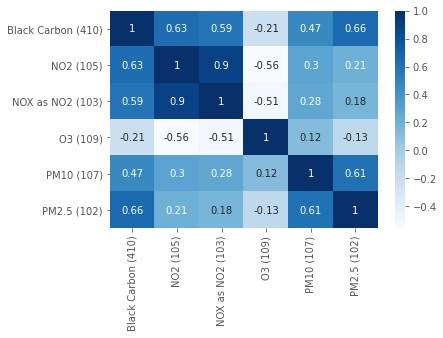

In [6]:
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

# Merging the air quality data with weather elements

In [7]:
def merge(df):
  # Merging temperature
  temp_raw = pd.read_csv("stockholmA-temp.csv",sep = ';', skiprows=9)
  cols_name = ['Datum','Tid (UTC)','Lufttemperatur']
  temp_raw = temp_raw[cols_name]
  temp_raw['Date'] = temp_raw['Datum']+' '+temp_raw['Tid (UTC)']
  cols = ['Date','Lufttemperatur']
  temp = temp_raw[cols]
  temp = temp.rename({'Date':'Datum'},axis=1)
  temp = temp.set_index('Datum')
  df = df.join(temp)

  # Merging Pressure
  pres_raw = pd.read_csv("stockholmA-pressure.csv",sep = ';', skiprows=9)
  col_names = ['Datum','Tid (UTC)','Lufttryck reducerat havsytans nivå']
  pres_raw = pres_raw[col_names]
  pres_raw['Datum'] = pres_raw['Datum']+' '+pres_raw['Tid (UTC)']
  cols = ['Datum','Lufttryck reducerat havsytans nivå']
  pres = pres_raw[cols]
  pres = pres.set_index('Datum')
  pres = pres.rename({'Lufttryck reducerat havsytans nivå':'pressure'},axis = 1)
  df = df.join(pres)

  # Merging RH
  rh_raw = pd.read_csv('stockholmA-RH.csv', sep = ';', skiprows = 9)
  rh_raw['Datum'] = rh_raw['Datum']+' '+rh_raw['Tid (UTC)']
  cols = ['Datum','Relativ Luftfuktighet']
  rh = rh_raw[cols]
  rh = rh.set_index('Datum')
  rh = rh.rename({'Relativ Luftfuktighet':'RH'}, axis=1)
  df = df.join(rh)

  # Merging Precipitation
  prec_raw = pd.read_csv('stockholm-precipitation.csv', sep = ';', skiprows = 9)
  prec_raw['Datum'] = prec_raw['Datum']+' '+prec_raw['Tid (UTC)']
  cols = ['Datum','Nederbördsmängd']
  prec = prec_raw[cols]
  prec = prec.set_index('Datum')
  prec = prec.rename({'Nederbördsmängd':'precipitation'}, axis=1)
  df = df.join(prec)

  return df

df = merge(df)
df.describe().transpose()


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,count,mean,std,min,25%,50%,75%,max
Black Carbon (410),15181.0,0.286541,0.256513,0.01,0.13,0.21,0.354,3.85
NO2 (105),43430.0,11.754000,10.531848,0.00,4.80,8.20,15.000,113.50
NOX as NO2 (103),43437.0,15.068653,17.426054,0.60,6.00,9.90,17.800,647.00
O3 (109),43666.0,51.786525,20.542881,0.10,38.40,52.00,65.500,151.20
PM10 (107),42076.0,12.186139,8.958793,-2.90,6.50,10.00,15.200,162.60
PM2.5 (102),42875.0,5.002183,4.569415,-3.00,2.20,3.70,6.300,59.30
Lufttemperatur,43801.0,8.425983,7.858121,-15.90,2.20,7.60,14.500,32.70
pressure,43799.0,1012.656668,11.582245,960.80,1005.60,1013.10,1020.200,1046.70
RH,43461.0,76.336647,18.289337,12.00,65.00,81.00,91.000,100.00
precipitation,43686.0,0.063666,0.377061,0.00,0.00,0.00,0.000,27.10


# Plots

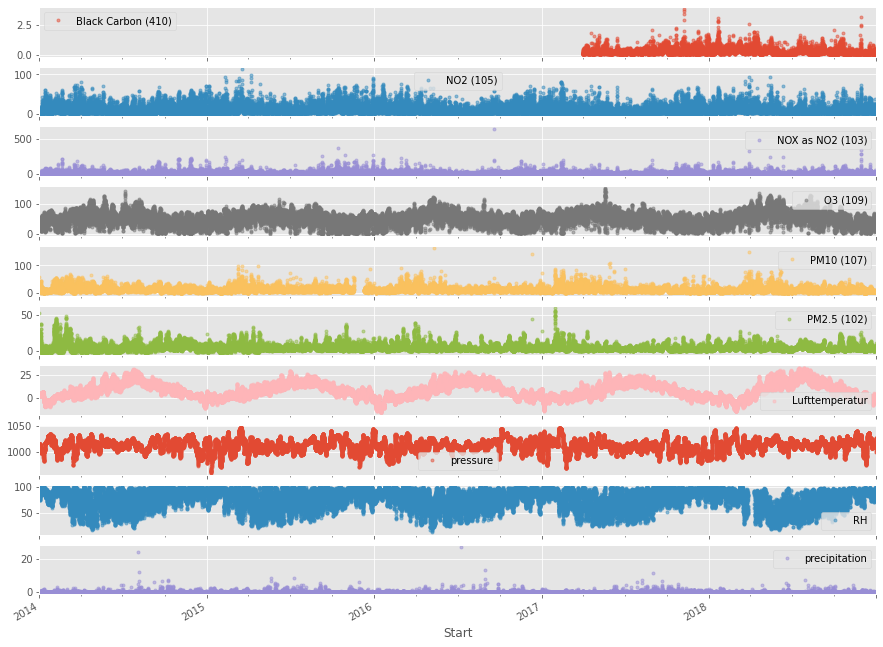

In [8]:
cols_plot = ['Black Carbon (410)','NO2 (105)','NOX as NO2 (103)','O3 (109)','PM10 (107)','PM2.5 (102)','Lufttemperatur','pressure','RH','precipitation']
axes = df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(15, 12), subplots=True)
for ax in axes:
    ax.set_ylabel('')

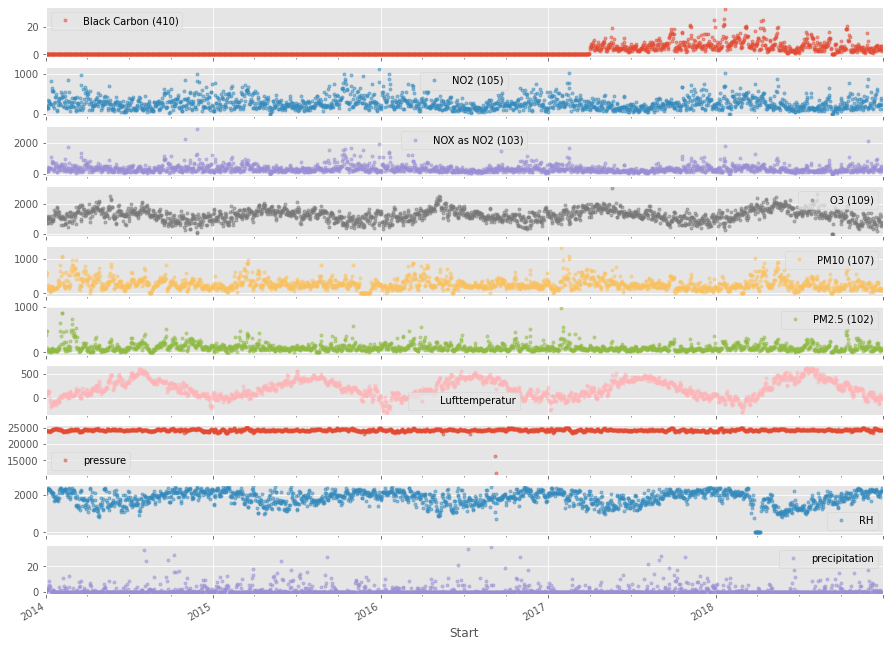

In [9]:
Daily = df.resample('D').sum()
cols_plot = ['Black Carbon (410)','NO2 (105)','NOX as NO2 (103)','O3 (109)','PM10 (107)','PM2.5 (102)','Lufttemperatur','pressure','RH','precipitation']
axes = Daily[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(15, 12), subplots=True)
for ax in axes:
    ax.set_ylabel('')

# Removing the rows with null values

191/191 [==============================] - 1s 7ms/step - loss: 0.1477 - mean_absolute_error: 0.2186
Performance on validation data {'Baseline': [0.19375759363174438, 0.23378898203372955], 'Linear': [0.17221292853355408, 0.2394314557313919], 'Dense': [0.168365940451622, 0.2537882328033447], 'Multi step dense': [0.15695150196552277, 0.22352977097034454], 'Conv': [0.14911991357803345, 0.2194463163614273], 'LSTM': [0.1476912498474121, 0.21859058737754822]}
Performance on test data {'Baseline': [0.364542156457901, 0.3494432866573334], 'Linear': [0.314043790102005, 0.3435954451560974], 'Dense': [0.31088894605636597, 0.3572811782360077], 'Multi step dense': [0.28606709837913513, 0.32627999782562256], 'Conv': [0.27019786834716797, 0.32014042139053345], 'LSTM': [0.27111300826072693, 0.31860366463661194]}


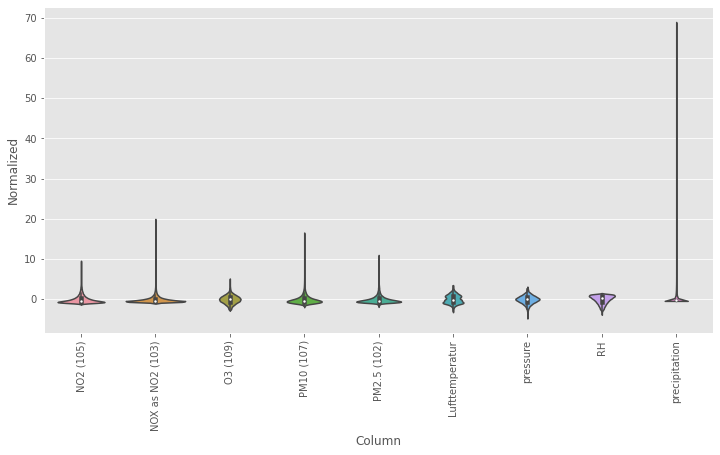

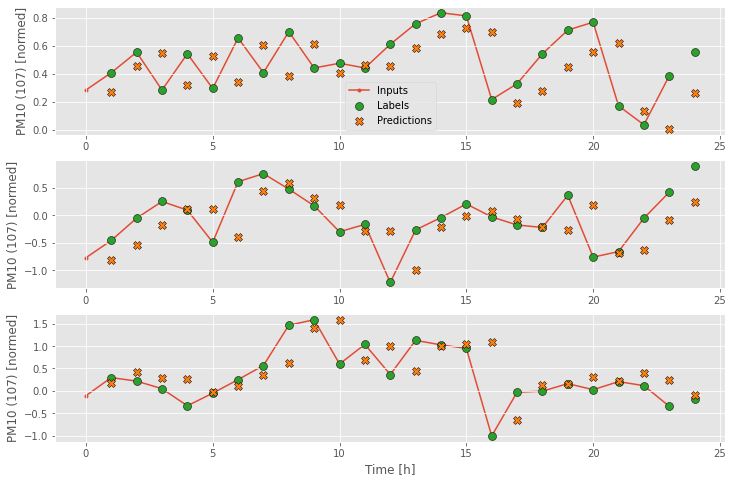

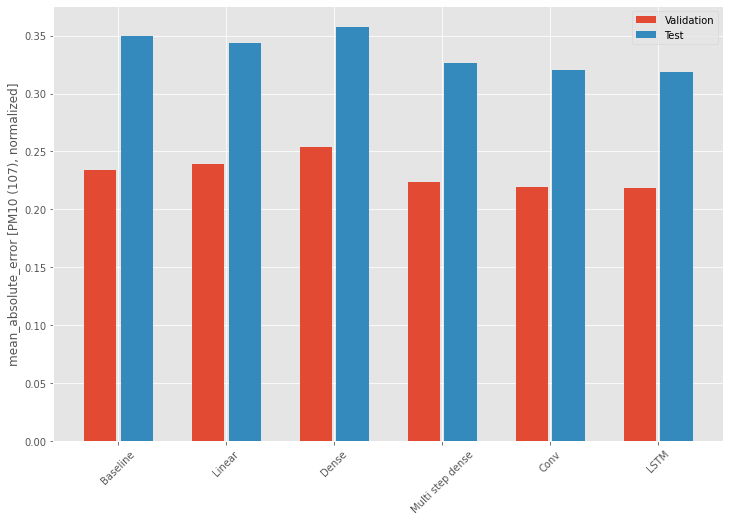

In [30]:
df_deleted = pd.read_csv("shair-8781-1-6-1.csv",sep = ';', skiprows=14,parse_dates=['Start'],index_col = 'Start')
del df_deleted['Black Carbon (410)']
df_deleted = merge(df_deleted)
df_deleted.dropna(inplace=True)
# missing_values(df_deleted)
df_deleted.info()
models(df_deleted)

# Replacing NaNs with the value from the previous row or the next row

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


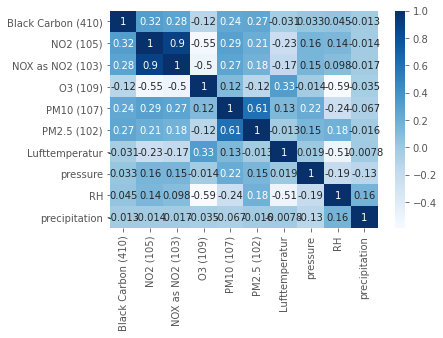

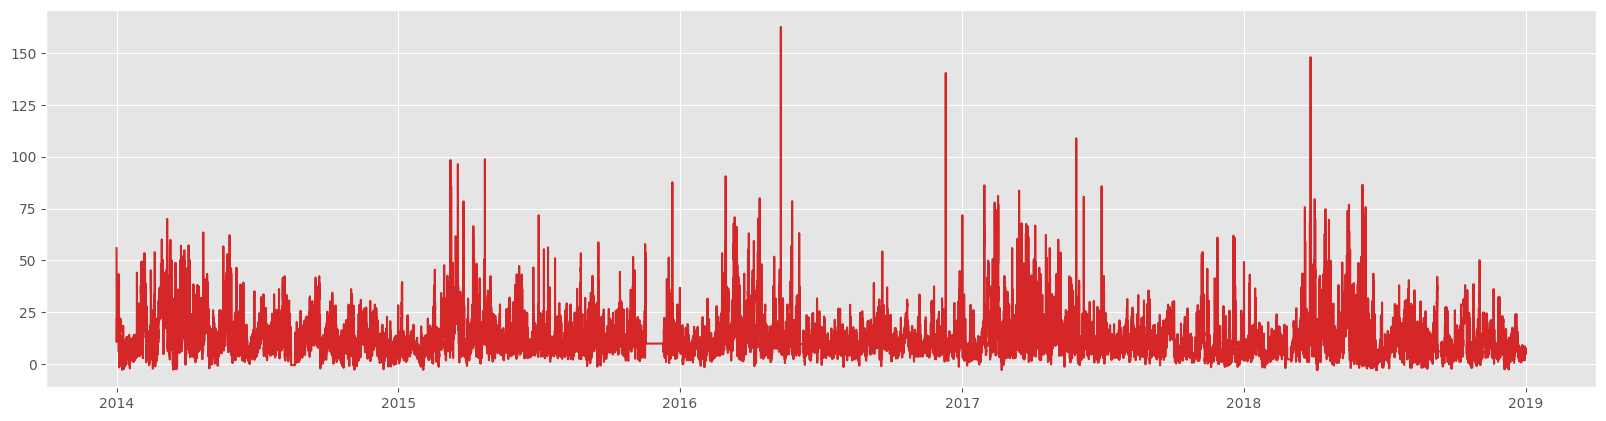

In [34]:
df_fillna_b = pd.read_csv("shair-8781-1-6-1.csv",sep = ';', skiprows=14,parse_dates=['Start'],index_col = 'Start')
df_fillna_b = merge(df_fillna_b)
df_fillna_b.fillna(method = 'bfill',inplace = True)
cor = df_fillna_b.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()
df_fillna_b.head()
# plot_df(df_fillna_b, x=df_fillna_b.index, y=df_fillna_b['PM10 (107)']) 
models(df_fillna_b)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


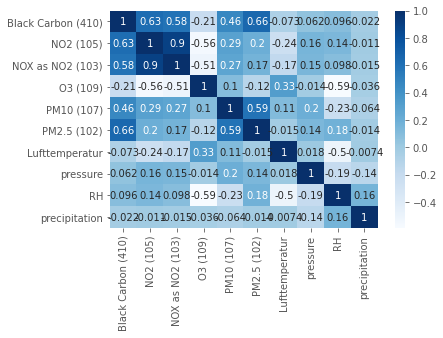

Baseline model
274/274 [==============================] - 1s 3ms/step - loss: 0.3495 - mean_absolute_error: 0.3010
Linear model
Epoch 1/20
959/959 [==============================] - 5s 5ms/step - loss: 0.6634 - mean_absolute_error: 0.4585 - val_loss: 0.4656 - val_mean_absolute_error: 0.3725
Epoch 2/20
959/959 [==============================] - 4s 5ms/step - loss: 0.3898 - mean_absolute_error: 0.3475 - val_loss: 0.3868 - val_mean_absolute_error: 0.3451
Epoch 3/20
959/959 [==============================] - 4s 5ms/step - loss: 0.3177 - mean_absolute_error: 0.3257 - val_loss: 0.3414 - val_mean_absolute_error: 0.3262
Epoch 4/20
959/959 [==============================] - 4s 5ms/step - loss: 0.2762 - mean_absolute_error: 0.3105 - val_loss: 0.3175 - val_mean_absolute_error: 0.3127
Epoch 5/20
959/959 [==============================] - 4s 5ms/step - loss: 0.2565 - mean_absolute_error: 0.3006 - val_loss: 0.3080 - val_mean_absolute_error: 0.3049
Epoch 6/20
959/959 [==============================] 

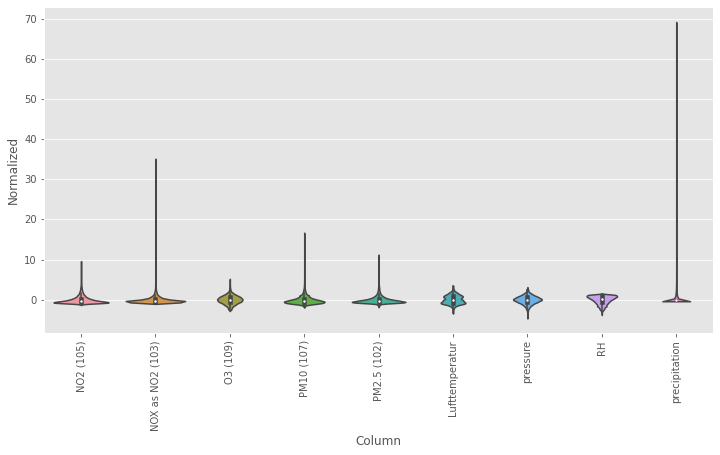

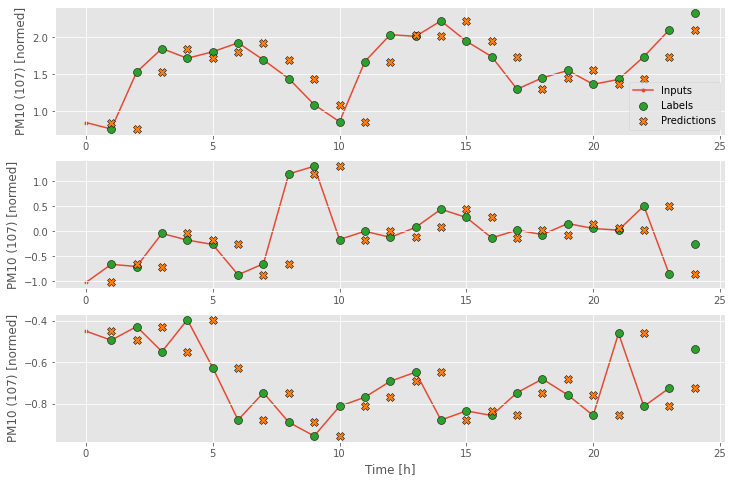

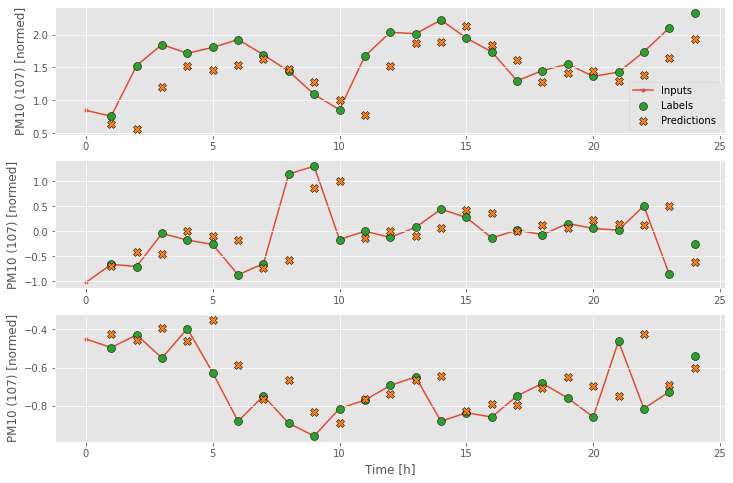

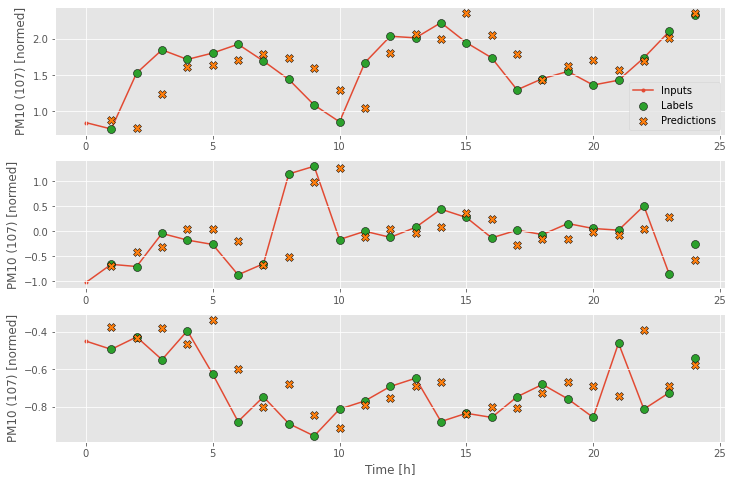

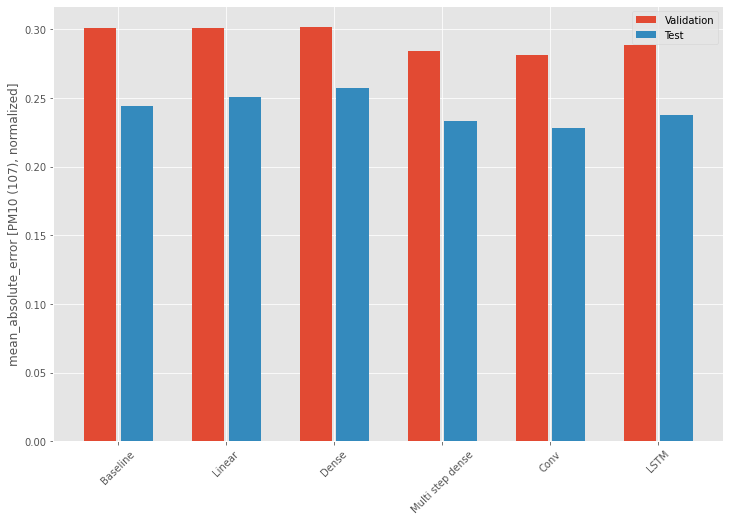

In [20]:
df_fillna_f = pd.read_csv("shair-8781-1-6-1.csv",sep = ';', skiprows=14,parse_dates=['Start'],index_col = 'Start')
df_fillna_f = merge(df_fillna_f)
df_fillna_f.fillna(method = 'ffill', inplace = True)
cor = df_fillna_f.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()
# df_fillna_b.head()
models(df_fillna_f)

# Replacing NaNs using Median/Mean of the column

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


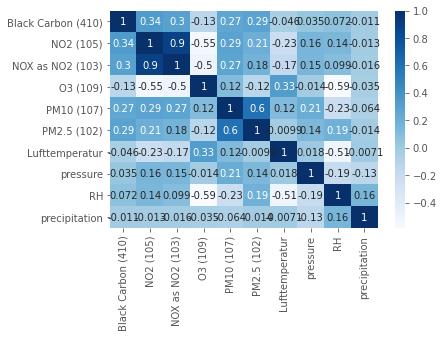

Baseline model
274/274 [==============================] - 1s 3ms/step - loss: 0.3669 - mean_absolute_error: 0.3099
Linear model
Epoch 1/20
959/959 [==============================] - 4s 4ms/step - loss: 1.0074 - mean_absolute_error: 0.6567 - val_loss: 0.4313 - val_mean_absolute_error: 0.3979
Epoch 2/20
959/959 [==============================] - 4s 4ms/step - loss: 0.3416 - mean_absolute_error: 0.3451 - val_loss: 0.3551 - val_mean_absolute_error: 0.3276
Epoch 3/20
959/959 [==============================] - 4s 4ms/step - loss: 0.2884 - mean_absolute_error: 0.3117 - val_loss: 0.3304 - val_mean_absolute_error: 0.3120
Epoch 4/20
959/959 [==============================] - 4s 4ms/step - loss: 0.2696 - mean_absolute_error: 0.3019 - val_loss: 0.3209 - val_mean_absolute_error: 0.3069
Epoch 5/20
959/959 [==============================] - 4s 4ms/step - loss: 0.2639 - mean_absolute_error: 0.2990 - val_loss: 0.3184 - val_mean_absolute_error: 0.3058
Epoch 6/20
959/959 [==============================] 

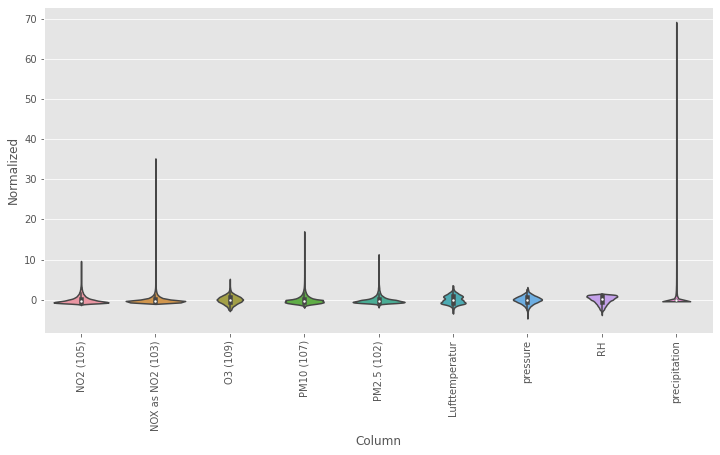

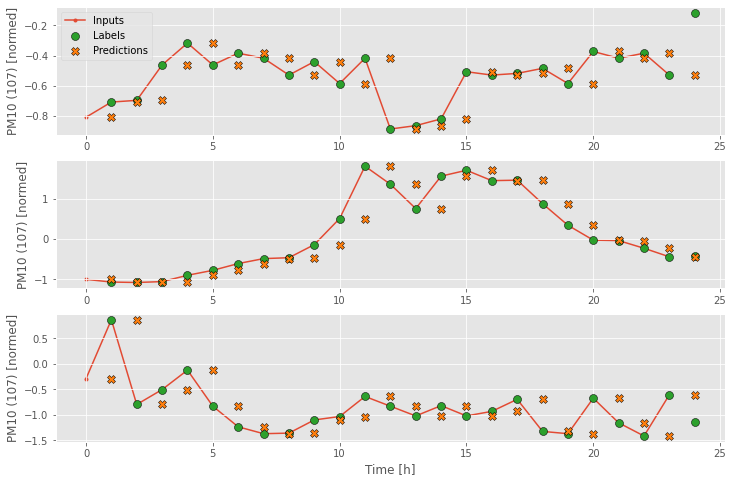

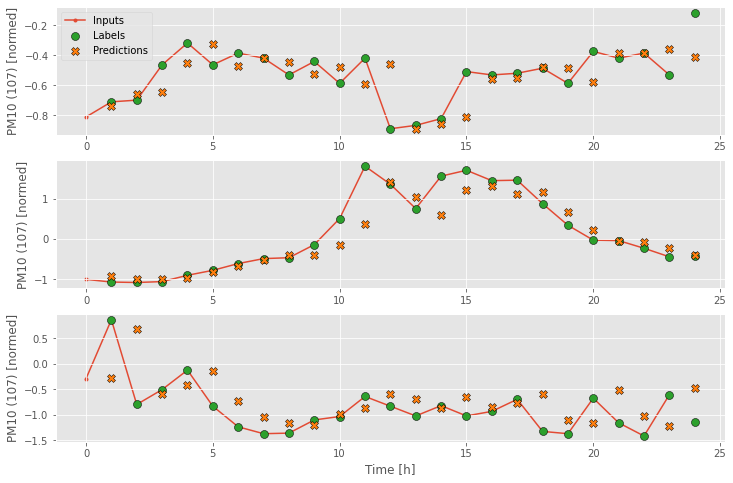

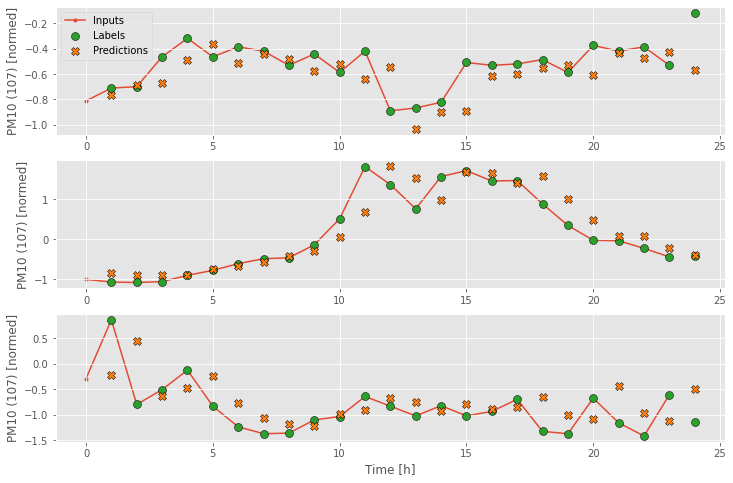

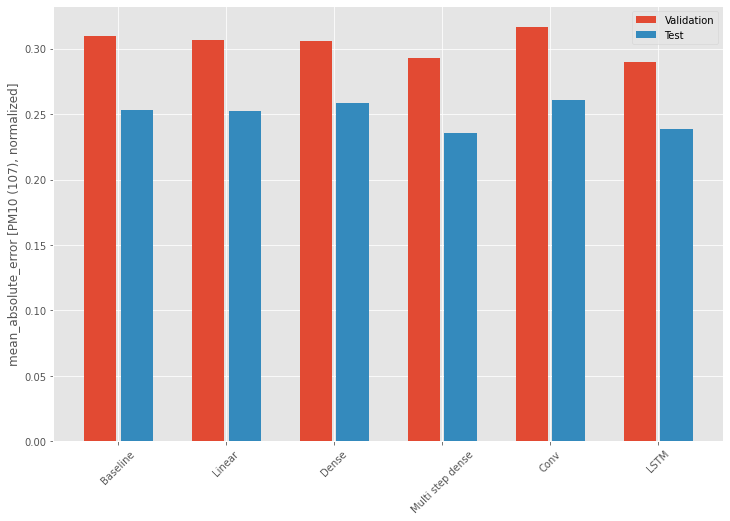

In [21]:
df_mean = pd.read_csv("shair-8781-1-6-1.csv",sep = ';', skiprows=14,parse_dates=['Start'],index_col = 'Start')
df_mean = merge(df_mean)
df_mean.fillna(df_mean.mean(),inplace = True)
for col in df.columns:
    if col != 'Slut':
        df_mean[col].fillna(df_mean[col].mean(), inplace = True)

df_mean.head()
cor = df_mean.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

models(df_mean)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


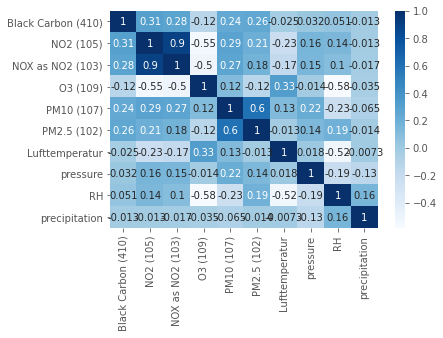

Baseline model
274/274 [==============================] - 1s 3ms/step - loss: 0.3647 - mean_absolute_error: 0.3088
Linear model
Epoch 1/20
959/959 [==============================] - 4s 5ms/step - loss: 0.5680 - mean_absolute_error: 0.4934 - val_loss: 0.3496 - val_mean_absolute_error: 0.3340
Epoch 2/20
959/959 [==============================] - 4s 4ms/step - loss: 0.2964 - mean_absolute_error: 0.3130 - val_loss: 0.3327 - val_mean_absolute_error: 0.3126
Epoch 3/20
959/959 [==============================] - 4s 5ms/step - loss: 0.2809 - mean_absolute_error: 0.3049 - val_loss: 0.3261 - val_mean_absolute_error: 0.3107
Epoch 4/20
959/959 [==============================] - 4s 4ms/step - loss: 0.2722 - mean_absolute_error: 0.3016 - val_loss: 0.3217 - val_mean_absolute_error: 0.3087
Epoch 5/20
959/959 [==============================] - 4s 4ms/step - loss: 0.2670 - mean_absolute_error: 0.2995 - val_loss: 0.3190 - val_mean_absolute_error: 0.3083
Epoch 6/20
959/959 [==============================] 

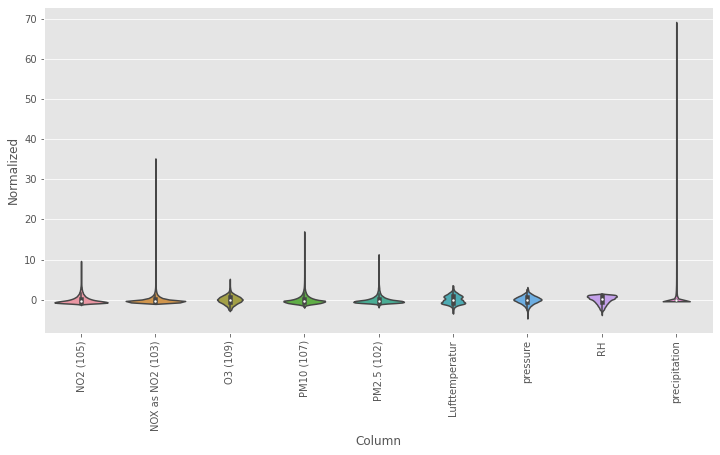

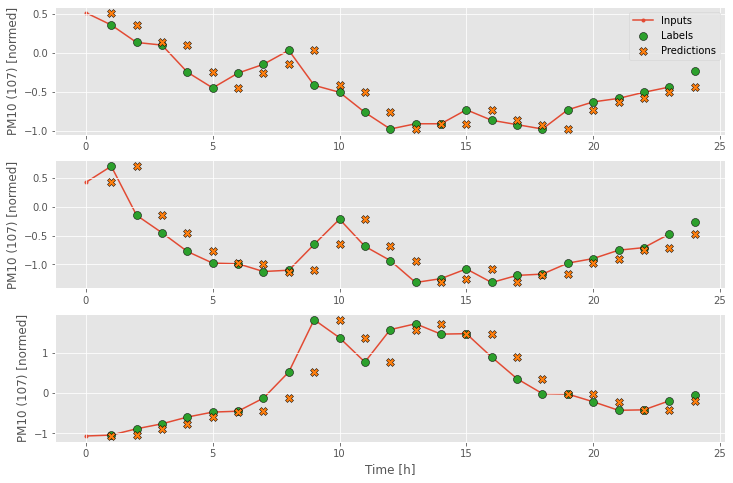

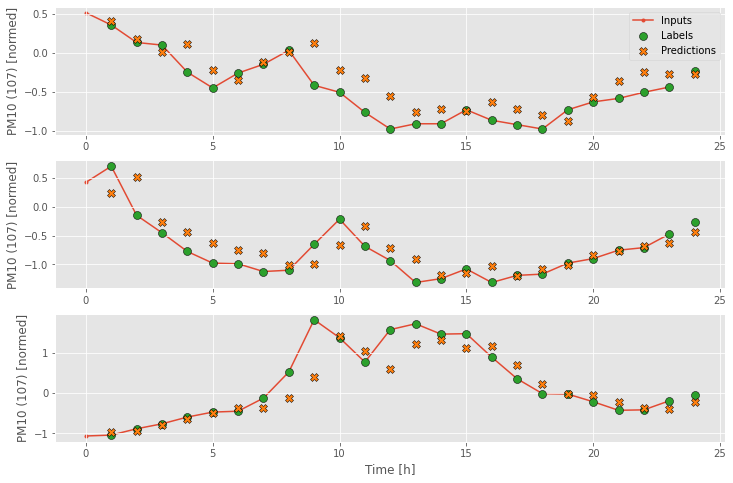

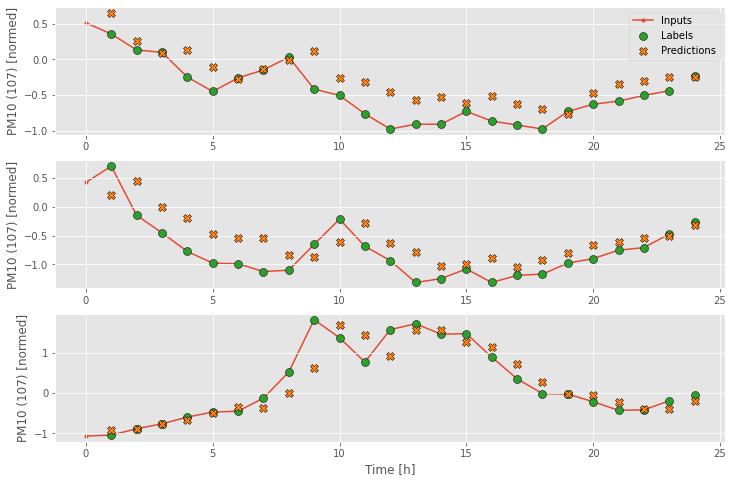

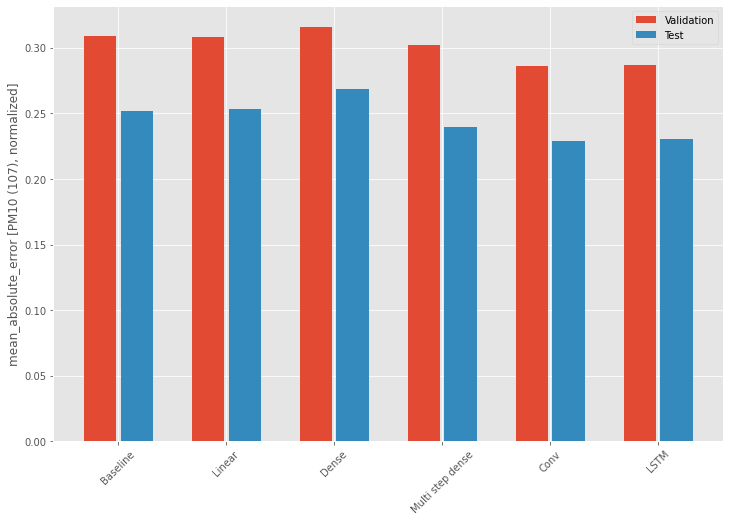

In [22]:
df_median =  pd.read_csv("shair-8781-1-6-1.csv",sep = ';', skiprows=14,parse_dates=['Start'],index_col = 'Start')
df_median = merge(df_median)
for col in df.columns:
    if col != 'Slut':
        df_median[col].fillna(df_median[col].median(), inplace = True)
        
df_median.head()    
cor = df_median.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

models(df_median)

# Using the interpolate method

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


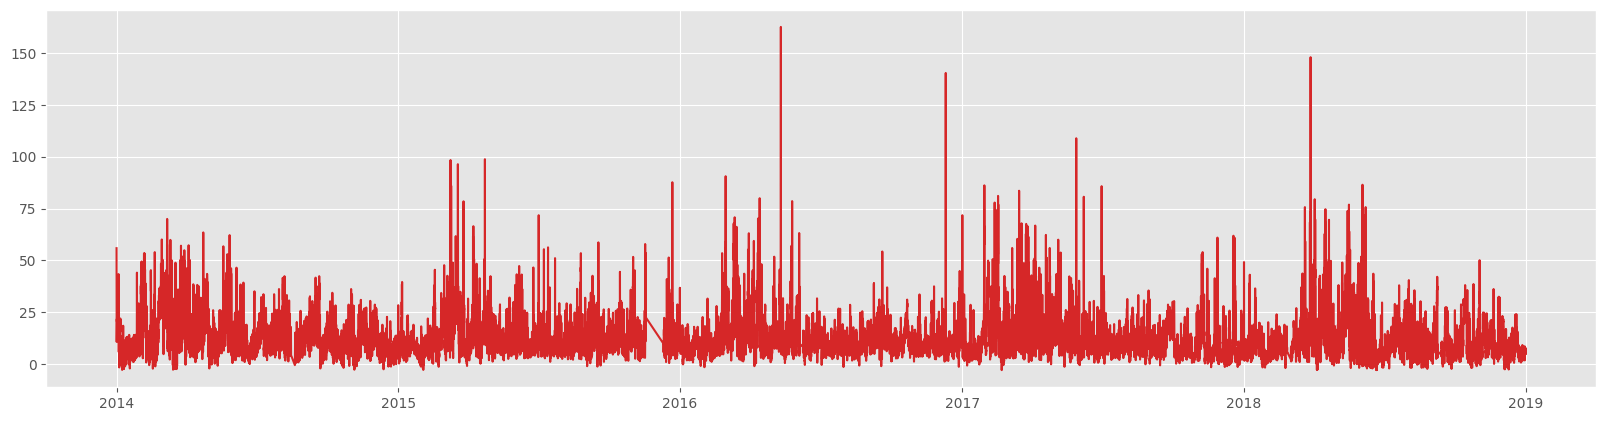

In [36]:
df_linear = pd.read_csv("shair-8781-1-6-1.csv",sep = ';', skiprows=14,parse_dates=['Start'],index_col = 'Start')
df_linear = merge(df_linear)
for col in df.columns:
    if col != 'Slut':
        df_linear[col].interpolate(method='linear', direction = 'forward', inplace=True) 
del df_linear['Black Carbon (410)']        
cor = df_linear.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()
# plot_df(df_linear, x=df_linear.index, y=df_linear['PM10 (107)']) 
models(df_linear)